In [3]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import librosa.display
import librosa
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from random import randint

In [4]:
path = './data'
dataset = load_dataset("speech_commands", "v0.01", cache_dir=path)

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
        num_rows: 51093
    })
    validation: Dataset({
        features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
        num_rows: 6799
    })
    test: Dataset({
        features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
        num_rows: 3081
    })
})

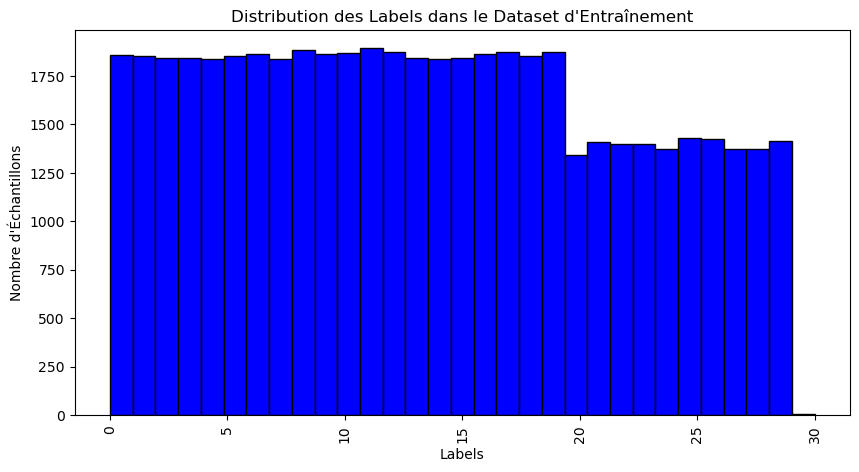

In [5]:
# Créer une liste de tous les labels
labels = [data['label'] for data in dataset['train']]

# Dessiner l'histogramme
plt.figure(figsize=(10, 5))
plt.hist(labels, bins=len(set(labels)), color='blue', edgecolor='black')
plt.title('Distribution des Labels dans le Dataset d\'Entraînement')
plt.xlabel('Labels')
plt.ylabel('Nombre d\'Échantillons')
plt.xticks(rotation=90)
plt.show()


In [10]:
def extract_features(audio, sr=16000, n_mfcc=40, max_pad_len=49):
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    pad_width = max_pad_len - mfccs.shape[1]
    if pad_width > 0:  # Si le nombre de colonnes dans mfccs est moins que max_pad_len
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:  # Si le nombre de colonnes dans mfccs est plus que max_pad_len
        mfccs = mfccs[:, :max_pad_len]
    return mfccs.flatten()


# Fonction pour échantillonner des exemples de bruit de fond (_silence_)
def sample_noise(audio_array, sr=16000):
    random_offset = randint(0, len(audio_array) - sr)
    return audio_array[random_offset : random_offset + sr]

def convert_labels(label):
    if label < 10: # Les labels de 0 à 9 sont les mêmes que les labels originaux
        return label
    elif 10 <= label < 30:
        return 10  # "_unknown_"
    else:
        return 11 # "_silence_"
    
# Préparation des données
def prepare_data(dataset, convert=True):
    X, y = [], []
    for data in dataset:
        audio_array = data['audio']['array']
        label = data['label']
        # Appliquer l'échantillonnage du bruit si nécessaire
        if label == 30:  # "_silence_"
            audio_array = sample_noise(audio_array)
        mfccs = extract_features(audio_array)
        X.append(mfccs.flatten())
        y.append(label)

    if convert: # Convertir les labels en 12 classes (10 chiffres, _unknown_, _silence_)
        y = [label for label in y]
    return np.array(X), np.array(y)


In [12]:
X_train, y_train = prepare_data(dataset['train'])
X_val, y_val = prepare_data(dataset['validation'])
X_test, y_test = prepare_data(dataset['test'])

In [ ]:
# Entraînement du modèle de régression logistique
log_reg = LogisticRegression(max_iter=150)
log_reg.fit(X_train, y_train)

# Évaluation du modèle sur l'ensemble de validation
y_val_pred = log_reg.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy}')

# Évaluation du modèle sur l'ensemble de test
y_test_pred = log_reg.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy}')

Validation Accuracy: 0.6492131195764083
Test Accuracy: 0.25543654657578707


c:\Users\Saliou\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.38      0.51       256
           1       0.55      0.07      0.12       252
           2       0.25      0.16      0.20       272
           3       0.65      0.04      0.08       253
           4       0.53      0.15      0.23       267
           5       0.63      0.05      0.09       259
           6       0.66      0.24      0.35       246
           7       0.56      0.39      0.46       262
           8       0.75      0.36      0.48       249
           9       0.50      0.11      0.18       251
          10       0.11      0.91      0.20       257
          11       1.00      0.21      0.35       257

    accuracy                           0.26      3081
   macro avg       0.58      0.26      0.27      3081
weighted avg       0.58      0.26      0.27      3081



In [ ]:
#afficher les labels important et ceux qui ne le sont pas (_unknown_= true or false) )
notImport_labels = []
for data in dataset["train"]:
    if data['is_unknown'] == True :
        notImport_labels.append(data['label'])

In [ ]:
print(len(dataset["train"]), len(notImport_labels))
print(np.unique(np.array(notImport_labels)))